In [1]:
import pandas as pd
import scanpy as sc
import numpy as np  

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad 
import scanpy.external as sce


In [2]:
human_1 = pd.read_csv("GSM2230757_human1_umifm_counts.csv")
human_1.insert(human_1.columns.get_loc("barcode") + 1, "sample", "batch_1")

human_2 = pd.read_csv("GSM2230758_human2_umifm_counts.csv")
human_2.insert(human_2.columns.get_loc("barcode") + 1, "sample", "batch_2")

human_4 = pd.read_csv("GSM2230760_human4_umifm_counts.csv")
human_4.insert(human_4.columns.get_loc("barcode") + 1, "sample", "batch_4")


human_3 = pd.read_csv("GSM2230759_human3_umifm_counts.csv")
human_3.insert(human_3.columns.get_loc("barcode") + 1, "sample", "batch_3")

human_reference = pd.concat([human_1, human_2,human_3, human_4])

In [3]:
human_reference_data = human_reference.loc[:, 'A1BG':]
obs = human_reference[["Unnamed: 0", "barcode","sample", "assigned_cluster"]]
obs.rename(columns={'assigned_cluster': 'cell_type'}, inplace=True)

var = human_reference_data.transpose().index.to_frame(index=False)
var.rename(columns={0: 'features'}, inplace=True)

# Create AnnData object
adata = ad.AnnData(
    X=np.array(human_reference_data),        # counts data
    obs=obs,                                 # Rows (samples) as observations
    var=var                                  # Columns (genes) as variables 
        )

# Save the AnnData object
#adata_query.write("pancreas_reference_raw_full.h5ad")


/tmp/ipykernel_462893/49023618.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs.rename(columns={'assigned_cluster': 'cell_type'}, inplace=True)
/home/mlopezdecas/anaconda3/envs/conformals3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/mlopezdecas/anaconda3/envs/conformals3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/mlopezdecas/anaconda3/envs/conformals3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_name

In [4]:
adata

AnnData object with n_obs × n_vars = 8569 × 20125
    obs: 'Unnamed: 0', 'barcode', 'sample', 'cell_type'
    var: 'features'

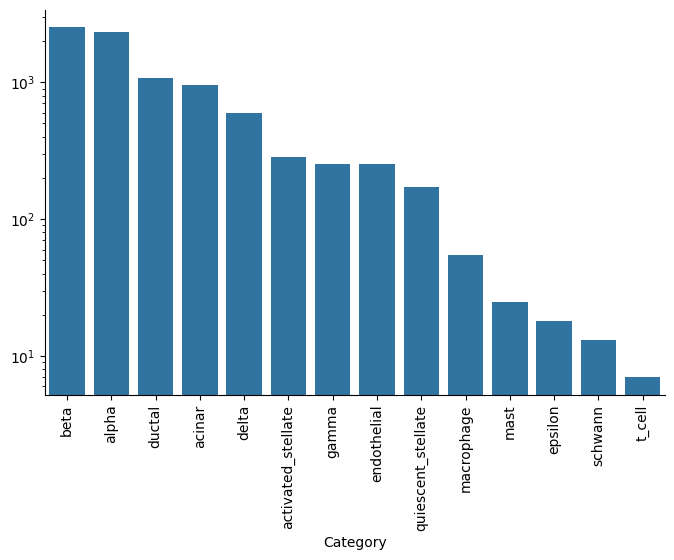

In [5]:
# Create the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=adata.obs["cell_type"].value_counts().index, 
            y=adata.obs["cell_type"].value_counts().values)

# Customize the plot
plt.xlabel("Category")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.yscale('log')  # Set y-axis to logarithmic scale
sns.despine()  # Remove top and right spines

# Show the plot
plt.show()

In [6]:
adata.obs["cell_type"].value_counts()

cell_type
beta                  2525
alpha                 2326
ductal                1077
acinar                 958
delta                  601
activated_stellate     284
gamma                  255
endothelial            252
quiescent_stellate     173
macrophage              55
mast                    25
epsilon                 18
schwann                 13
t_cell                   7
Name: count, dtype: int64

In [7]:
cells_OOD =["t_cell","schwann", "epsilon", "mast", "macrophage"] 

adata = adata[~adata.obs["cell_type"].isin(cells_OOD)].copy()

/home/mlopezdecas/anaconda3/envs/conformals3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")


In [9]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

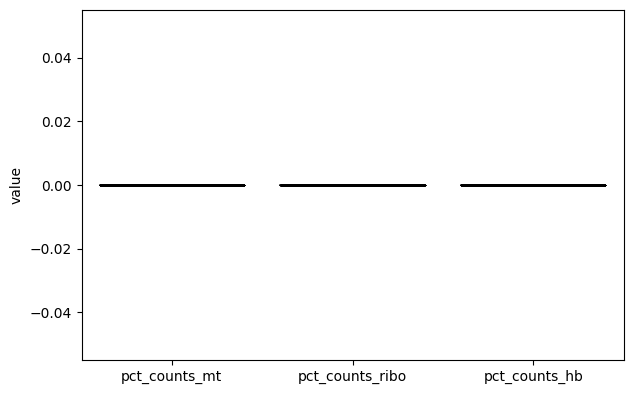

In [10]:
sc.pl.violin(
    adata,
    ["pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    multi_panel=False,
)

In [11]:
# Set QC thresholds
mt_threshold = 20  # Percentage of mitochondrial counts
ribo_threshold = 60  # Percentage of ribosomal counts
hb_threshold = 60 # Percentage of hemoglobin counts

# Apply QC filters
filter_condition = (
        (adata.obs["pct_counts_mt"] < mt_threshold) & 
        (adata.obs["pct_counts_ribo"] < ribo_threshold) &
        (adata.obs["pct_counts_hb"] < hb_threshold)
)

adata = adata[filter_condition]

In [12]:
adata

View of AnnData object with n_obs × n_vars = 8451 × 20125
    obs: 'Unnamed: 0', 'barcode', 'sample', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'features', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [13]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

/tmp/ipykernel_462893/1751348069.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()
/home/mlopezdecas/anaconda3/envs/conformals3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


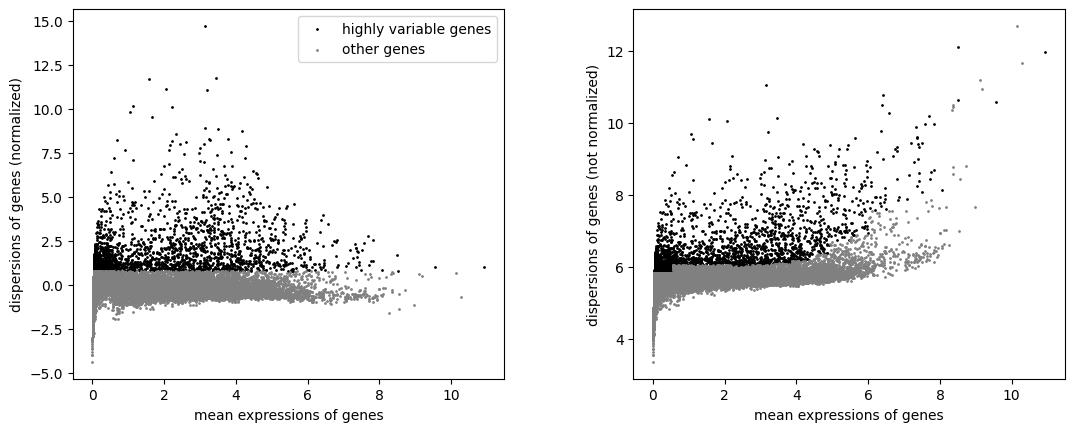

In [14]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

In [15]:
# Step 1: Select highly variable genes
adata_hvg = adata[:, adata.var['highly_variable']]

/home/mlopezdecas/anaconda3/envs/conformals3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/mlopezdecas/anaconda3/envs/conformals3/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/home/mlopezdecas/anaconda3/envs/conformals3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


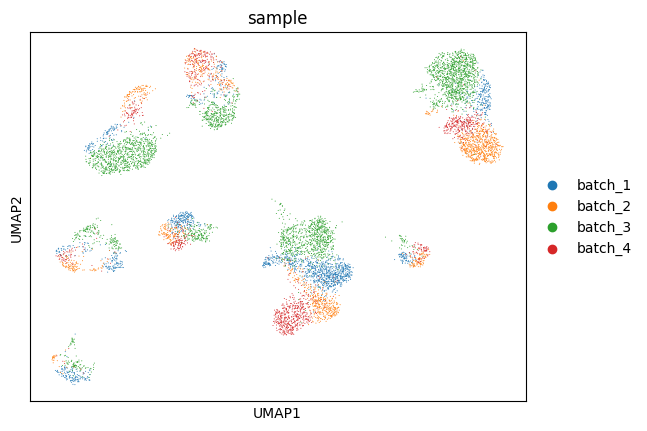

In [16]:
sc.pp.neighbors(adata_hvg)
sc.tl.umap(adata_hvg)
sc.pl.umap(adata_hvg,color="sample",size=2)

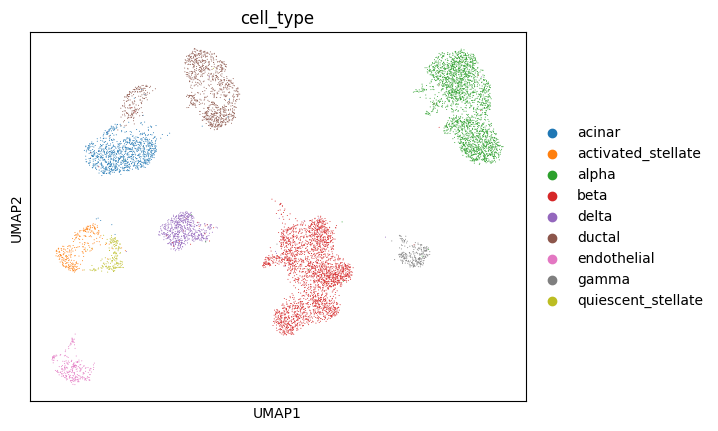

In [17]:
sc.pl.umap(adata_hvg,color="cell_type",size=2)

In [18]:
adata.write("breast_preprocessed.h5ad")

In [19]:
adata_hvg

AnnData object with n_obs × n_vars = 8451 × 2000
    obs: 'Unnamed: 0', 'barcode', 'sample', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'features', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

2025-02-15 17:49:57,598 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-02-15 17:49:58,158 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-02-15 17:49:58,178 - harmonypy - INFO - Iteration 1 of 50
2025-02-15 17:49:59,241 - harmonypy - INFO - Iteration 2 of 50
2025-02-15 17:50:00,272 - harmonypy - INFO - Iteration 3 of 50
2025-02-15 17:50:00,987 - harmonypy - INFO - Iteration 4 of 50
2025-02-15 17:50:01,406 - harmonypy - INFO - Iteration 5 of 50
2025-02-15 17:50:01,729 - harmonypy - INFO - Iteration 6 of 50
2025-02-15 17:50:02,109 - harmonypy - INFO - Converged after 6 iterations


check integration: 


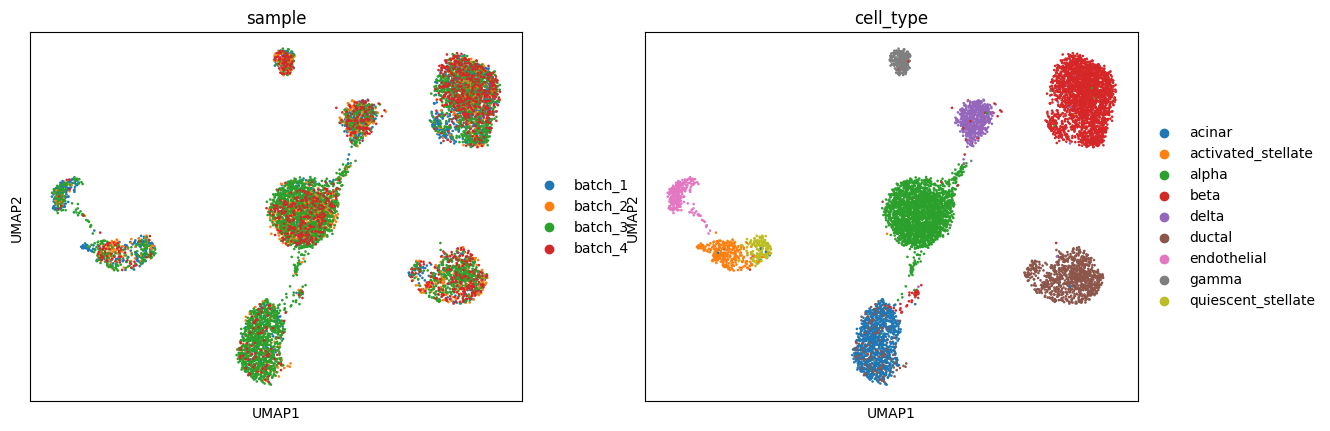

In [20]:



# Apply PCA
sc.pp.pca(adata_hvg)
# Run Harmony
sce.pp.harmony_integrate(adata_hvg, key="sample", max_iter_harmony=50, theta=1.5)

print("check integration: ")
sc.pp.neighbors(adata_hvg, use_rep="X_pca_harmony")
sc.tl.umap(adata_hvg)
# Visualize UMAP
sc.pl.umap(adata_hvg, color=["sample","cell_type" ])

In [21]:


# Step 2: Split datasets by 'surgery'""
adata_ref_1 = adata_hvg[adata_hvg.obs['sample'].isin(["batch_3", "batch_2", "batch_4"])].copy()
adata_query_1= adata_hvg[adata_hvg.obs['sample'] == 'batch_1'].copy()

adata_ref_1.write("pancreas_human_reference_HV_1.h5ad")
adata_query_1.write("pancreas_human_query_HV_1.h5ad")

# Step 2: Split datasets by 'surgery'""
adata_ref_2 = adata_hvg[adata_hvg.obs['sample'].isin(["batch_3", "batch_1", "batch_4"])].copy()
adata_query_2= adata_hvg[adata_hvg.obs['sample'] == 'batch_2'].copy()

adata_ref_2.write("pancreas_human_reference_HV_2.h5ad")
adata_query_2.write("pancreas_human_query_HV_2.h5ad")

# Step 2: Split datasets by 'surgery'""
adata_ref_3 = adata_hvg[adata_hvg.obs['sample'].isin(["batch_2", "batch_1", "batch_4"])].copy()
adata_query_3= adata_hvg[adata_hvg.obs['sample'] == 'batch_3'].copy()

adata_ref_3.write("pancreas_human_reference_HV_3.h5ad")
adata_query_3.write("pancreas_human_query_HV_3.h5ad")
 

# Step 2: Split datasets by 'surgery'""
adata_ref_4 = adata_hvg[adata_hvg.obs['sample'].isin(["batch_2", "batch_1", "batch_3"])].copy()
adata_query_4= adata_hvg[adata_hvg.obs['sample'] == 'batch_4'].copy()

adata_ref_4.write("pancreas_human_reference_HV_4.h5ad")
adata_query_4.write("pancreas_human_query_HV_4.h5ad")


/home/mlopezdecas/anaconda3/envs/conformals3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/mlopezdecas/anaconda3/envs/conformals3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/mlopezdecas/anaconda3/envs/conformals3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/mlopezdecas/anaconda3/envs/conformals3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [1]:
import scanpy as sc

In [16]:
adata_ref = sc.read("pancreas_human_reference_HV_4.h5ad")
adata_query = sc.read("pancreas_human_query_HV_4.h5ad")

/home/mlopezdecas/anaconda3/envs/conformals3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [18]:
adata_ref

AnnData object with n_obs × n_vars = 7162 × 2000
    obs: 'Unnamed: 0', 'barcode', 'sample', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'features', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [19]:
len(adata_ref.obs["cell_type"].value_counts())

9

In [24]:
adata_query_1.obs["cell_type"].value_counts()

cell_type
beta                  495
alpha                 284
ductal                280
delta                 101
gamma                  63
activated_stellate     52
endothelial             7
quiescent_stellate      5
acinar                  2
Name: count, dtype: int64

In [1]:

import scanpy as sc
import pandas as pd

# Load Experiment 1 datasets
adata_ref1 = sc.read_h5ad("pancreas_human_reference_HV_1.h5ad")
adata_query1 = sc.read_h5ad("pancreas_human_query_HV_1.h5ad")

# Load Experiment 2 datasets
adata_ref2 = sc.read_h5ad("pancreas_human_reference_HV_2.h5ad")
adata_query2 = sc.read_h5ad("pancreas_human_query_HV_2.h5ad")

# Load Experiment 1 datasets
adata_ref3 = sc.read_h5ad("pancreas_human_reference_HV_3.h5ad")
adata_query3 = sc.read_h5ad("pancreas_human_query_HV_3.h5ad")

# Load Experiment 2 datasets
adata_ref4 = sc.read_h5ad("pancreas_human_reference_HV_4.h5ad")
adata_query4 = sc.read_h5ad("pancreas_human_query_HV_4.h5ad")

# Get cell type counts for each split
counts_ref1 = adata_ref1.obs["cell_type"].value_counts()
counts_query1 = adata_query1.obs["cell_type"].value_counts()
counts_ref2 = adata_ref2.obs["cell_type"].value_counts()
counts_query2 = adata_query2.obs["cell_type"].value_counts()

counts_ref3 = adata_ref3.obs["cell_type"].value_counts()
counts_query3 = adata_query3.obs["cell_type"].value_counts()
counts_ref4 = adata_ref4.obs["cell_type"].value_counts()
counts_query4 = adata_query4.obs["cell_type"].value_counts()

# Create a union of all cell types observed across splits
cell_types = set(counts_ref1.index).union(counts_query1.index, counts_ref2.index, counts_query2.index, counts_ref3.index, counts_query3.index, counts_ref4.index, counts_query4.index)

# Build a DataFrame summarizing the counts
data = []
for ct in sorted(cell_types):
    ref1 = counts_ref1.get(ct, 0)
    query1 = counts_query1.get(ct, 0)
    ref2 = counts_ref2.get(ct, 0)
    query2 = counts_query2.get(ct, 0)
    ref3 = counts_ref3.get(ct, 0)
    query3 = counts_query3.get(ct, 0)
    ref4 = counts_ref4.get(ct, 0)
    query4 = counts_query4.get(ct, 0)
    data.append({
        'Cell Type': ct,
        'Exp1 Ref': ref1,
        'Exp1 Query': query1,
        'Exp2 Ref': ref2,
        'Exp2 Query': query2,
        'Exp3 Ref': ref3,
        'Exp3 Query': query3,
        'Exp4 Ref': ref4,
        'Exp4 Query': query4
    })
df = pd.DataFrame(data)

totals = {
    'Exp1 Ref': df['Exp1 Ref'].sum(),
    'Exp1 Query': df['Exp1 Query'].sum(),
    'Exp2 Ref': df['Exp2 Ref'].sum(),
    'Exp2 Query': df['Exp2 Query'].sum(),
    'Exp3 Ref': df['Exp3 Ref'].sum(),
    'Exp3 Query': df['Exp3 Query'].sum(),
    'Exp4 Ref': df['Exp4 Ref'].sum(),
    'Exp4 Query': df['Exp4 Query'].sum()
}



for idx, row in df.iterrows():
    exp1_ref_perc = row['Exp1 Ref'] / totals['Exp1 Ref'] * 100
    exp1_query_perc = row['Exp1 Query'] / totals['Exp1 Query'] * 100
    exp2_ref_perc = row['Exp2 Ref'] / totals['Exp2 Ref'] * 100
    exp2_query_perc = row['Exp2 Query'] / totals['Exp2 Query'] * 100
    exp3_ref_perc = row['Exp3 Ref'] / totals['Exp3 Ref'] * 100
    exp3_query_perc = row['Exp3 Query'] / totals['Exp3 Query'] * 100
    exp4_ref_perc = row['Exp4 Ref'] / totals['Exp4 Ref'] * 100
    exp4_query_perc = row['Exp4 Query'] / totals['Exp4 Query'] * 100
    
    print(f"{row['Cell Type']} & "
          f"{row['Exp1 Ref']} ({exp1_ref_perc:.0f}\\%) & {row['Exp1 Query']} ({exp1_query_perc:.0f}\\%) & "
          f"{row['Exp2 Ref']} ({exp2_ref_perc:.0f}\\%) & {row['Exp2 Query']} ({exp2_query_perc:.0f}\\%) & "
          f"{row['Exp3 Ref']} ({exp3_ref_perc:.0f}\\%) & {row['Exp3 Query']} ({exp3_query_perc:.0f}\\%) & "
          f"{row['Exp4 Ref']} ({exp4_ref_perc:.0f}\\%) & {row['Exp4 Query']} ({exp4_query_perc:.0f}\\%) \\\\")

# Print totals row (without percentages)
print(f"\\textbf{{Total}} & {totals['Exp1 Ref']} & {totals['Exp1 Query']} & {totals['Exp2 Ref']} & {totals['Exp2 Query']} & "
      f"{totals['Exp3 Ref']} & {totals['Exp3 Query']} & {totals['Exp4 Ref']} & {totals['Exp4 Query']} \\\\")
    

/home/mlopezdecas/anaconda3/envs/conformals3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/mlopezdecas/anaconda3/envs/conformals3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/mlopezdecas/anaconda3/envs/conformals3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


acinar & 848 (13\%) & 110 (6\%) & 955 (14\%) & 3 (0\%) & 115 (2\%) & 843 (24\%) & 956 (13\%) & 2 (0\%) \\
activated_stellate & 233 (4\%) & 51 (3\%) & 203 (3\%) & 81 (5\%) & 184 (4\%) & 100 (3\%) & 232 (3\%) & 52 (4\%) \\
alpha & 2090 (32\%) & 236 (12\%) & 1650 (24\%) & 676 (40\%) & 1196 (25\%) & 1130 (32\%) & 2042 (29\%) & 284 (22\%) \\
beta & 1653 (25\%) & 872 (46\%) & 2154 (32\%) & 371 (22\%) & 1738 (36\%) & 787 (22\%) & 2030 (28\%) & 495 (38\%) \\
delta & 387 (6\%) & 214 (11\%) & 476 (7\%) & 125 (7\%) & 440 (9\%) & 161 (4\%) & 500 (7\%) & 101 (8\%) \\
ductal & 957 (15\%) & 120 (6\%) & 776 (11\%) & 301 (18\%) & 701 (14\%) & 376 (11\%) & 797 (11\%) & 280 (22\%) \\
endothelial & 122 (2\%) & 130 (7\%) & 229 (3\%) & 23 (1\%) & 160 (3\%) & 92 (3\%) & 245 (3\%) & 7 (1\%) \\
gamma & 185 (3\%) & 70 (4\%) & 169 (2\%) & 86 (5\%) & 219 (4\%) & 36 (1\%) & 192 (3\%) & 63 (5\%) \\
quiescent_stellate & 81 (1\%) & 92 (5\%) & 151 (2\%) & 22 (1\%) & 119 (2\%) & 54 (2\%) & 168 (2\%) & 5 (0\%) \\
\textb

/home/mlopezdecas/anaconda3/envs/conformals3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
